### Using Python to read and write shapefile
Most of urban data are spatial data. Therefore, it is important to use Python to read, write, and operate shapefile. In this tutorial, we are going to use Python and several geospatial modules for spatial data operations. 

### 1. The easiest module is `GeoPandas`
GeoPandas is a project to add support for geographic data to pandas objects. GeoPandas provides a easy solution to read, write, and conduct operations shapefiles. 

In [37]:
import geopandas as gpd

censusMap = gpd.read_file("census-tract-data/census-tract-data.shp")
censusMap.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,fema_65_66,fema_67_69,fema70_74,fema75_79,fema80_84,fema85_,state,county,tract,geometry
0,42,101,014500,42101014500,145,Census Tract 145,G5020,S,321465,0,...,25,46,33,7,17,28,42,101,014500,"POLYGON ((-75.15162 39.97496, -75.15131 39.976..."
1,42,101,031200,42101031200,312,Census Tract 312,G5020,S,429735,0,...,42,63,202,48,0,11,42,101,031200,"POLYGON ((-75.08417 40.03231, -75.08402 40.032..."
2,42,101,021800,42101021800,218,Census Tract 218,G5020,S,1006008,0,...,0,84,55,98,27,17,42,101,021800,"POLYGON ((-75.23807 40.05988, -75.23622 40.061..."
3,42,101,009100,42101009100,91,Census Tract 91,G5020,S,425574,0,...,62,33,131,42,42,53,42,101,009100,"POLYGON ((-75.20224 39.96164, -75.20142 39.961..."
4,42,101,033600,42101033600,336,Census Tract 336,G5020,S,1153477,0,...,74,86,80,28,72,48,42,101,033600,"POLYGON ((-75.06807 40.06082, -75.06692 40.062..."


In [7]:
censusMap.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME_x', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'NAME_y', 'GEO_ID', 'white_popu', 'non-hispan', 'black_popu',
       'asian_popu', 'hispanic_p', 'total_popu', 'median_hou', 'per_capita',
       'built_age', 'less_highs', 'bachelor', 'totaleduca', 'male_und18',
       'female_und', 'male65_66', 'male67_69', 'male70_74', 'male75_79',
       'male80_84', 'male85_', 'fema_65_66', 'fema_67_69', 'fema70_74',
       'fema75_79', 'fema80_84', 'fema85_', 'state', 'county', 'tract',
       'geometry'],
      dtype='object')

We are going to calculate the proportion of differet racial/ethnic groups in Philadelphia

In [9]:
censusMap['propWhite'] = censusMap['white_popu'].astype(float)/censusMap['total_popu'].astype(float)

#### Write to a shapefile

<Axes: >

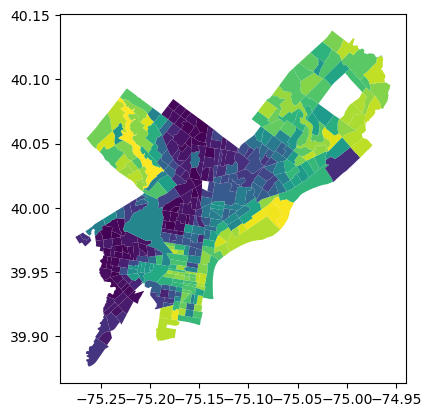

In [15]:
censusMap.to_file('census-tract-data/prop_popu.shp')

censusMap.plot('propWhite', legend=True)

### 2. The medium level in terms of flexibility and easy-to-use `Fiona`
While the geopandas make reading and writing pretty easy in Python. However, in many (a lot) of cases, you may find geopandas cannot provide the flexibility for some operations. The `geopandas` is developed based on `fiona` together with several other modules. In this session, we will know how to use `fiona` to read, write, and operation shapefile. 

In [5]:
# get the meta data of shapefile, such as spatial reference, field names, etc
import fiona
from fiona.crs import to_string
from shapely.geometry import shape
from fiona.crs import from_epsg

neighborhood_shp = 'census-tract-data/census-tract-data.shp'

nb_lyr = fiona.open(neighborhood_shp, 'r')

In [10]:
import geopandas as gpd
df = gpd.read_file('census-tract-data/census-tract-data.shp')
df_proj = df.to_crs(epsg=2272)
df_proj.to_file('census-tract-data/census-tract-data-reproj.shp', driver='ESRI Shapefile')


#### Access the metadata of the shapefile
We can easily access the spatial reference, table structure of the shapefile. 

In [ ]:
meta = nb_lyr.meta # more details about the metadata of the shapefile
meta

We can be more specific to get the `crs`: coordinate reference system, and `schema`. 

In [ ]:
driver = nb_lyr.driver # the driver of the shapefile
schema = nb_lyr.schema  #schema of shapefile
crs = nb_lyr.crs   # coordinate reference system of the shapefile
crs, schema

#### Loop features in the layer
There are many features (points, polygons) in shapefile. We can use `fiona` to loop all fetures and access the geometry and attributes of each feature. 

In [8]:
for feat in nb_lyr:
    # attribute of the neighborhood features
    attr = feat['properties']
    name = attr['TRACTCE']  #you can find other attribute based on the metadata of the shapefile
    print ('The neighborhod is:', name)
    
    # get the geometry of the polygon feature
    geom = feat['geometry']
    # print ('geom is:', geom)
    

### 3. Write shapefile using `fiona`
In order to write shapefile, we need to first prepare the metadata. We can prepare the metata from scatch or modify based on existing shapefile. 

Let prepare the metadata from scratch. 

In [13]:
schema = { 
  'geometry': 'Point', 
  'properties': { 'id': 'int', 'name': 'str:10' } 
}

crs = {'init': 'epsg:4326'} #from_epsg(4326)


Then we can write a shapefile

In [14]:
from shapely.geometry import LineString, Polygon, Point
from shapely.geometry import shape, mapping
import random
import fiona


outfile = 'out.shp'
min_x, max_x = -75.380, -74.943
min_y, max_y = 39.912, 40.124

# do map-matching for all traj and save them into one shapefile
with fiona.open(outfile, 'w', crs = crs, driver='ESRI Shapefile', schema = schema) as out:
    for i in range(100):
        ## we create 100 random point, within the boundary of Philadelphia
        lon, lat = (random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        
        ## prepare the feature, this should have the same structure as the schema you just defined.
        feature = {'geometry': mapping(Point(lon, lat)), 
                    'properties': {
                                     'id': i,
                                     'name': 'random point'
                                  }
                  }
        
        out.write(feature)
        

#### Using the schema of existing shapefile
In most cases, we can use the schema of existing shapefile or we can modify it. Let create a new shapefile of philadelphia census data. We can add a new column. 

In [15]:
nb_lyr.schema

{'properties': OrderedDict([('STATEFP', 'str:80'),
              ('COUNTYFP', 'str:80'),
              ('TRACTCE', 'str:80'),
              ('GEOID', 'str:80'),
              ('NAME_x', 'str:80'),
              ('NAMELSAD', 'str:80'),
              ('MTFCC', 'str:80'),
              ('FUNCSTAT', 'str:80'),
              ('ALAND', 'int:18'),
              ('AWATER', 'int:18'),
              ('INTPTLAT', 'str:80'),
              ('INTPTLON', 'str:80'),
              ('NAME_y', 'str:80'),
              ('GEO_ID', 'str:80'),
              ('white_popu', 'str:80'),
              ('non-hispan', 'str:80'),
              ('black_popu', 'str:80'),
              ('asian_popu', 'str:80'),
              ('hispanic_p', 'str:80'),
              ('total_popu', 'str:80'),
              ('median_hou', 'str:80'),
              ('per_capita', 'str:80'),
              ('built_age', 'str:80'),
              ('less_highs', 'str:80'),
              ('bachelor', 'str:80'),
              ('totaleduca', 'str:80

In [16]:
schema = nb_lyr.schema.copy()
schema['properties']['id'] = "str:4"
schema

{'properties': OrderedDict([('STATEFP', 'str:80'),
              ('COUNTYFP', 'str:80'),
              ('TRACTCE', 'str:80'),
              ('GEOID', 'str:80'),
              ('NAME_x', 'str:80'),
              ('NAMELSAD', 'str:80'),
              ('MTFCC', 'str:80'),
              ('FUNCSTAT', 'str:80'),
              ('ALAND', 'int:18'),
              ('AWATER', 'int:18'),
              ('INTPTLAT', 'str:80'),
              ('INTPTLON', 'str:80'),
              ('NAME_y', 'str:80'),
              ('GEO_ID', 'str:80'),
              ('white_popu', 'str:80'),
              ('non-hispan', 'str:80'),
              ('black_popu', 'str:80'),
              ('asian_popu', 'str:80'),
              ('hispanic_p', 'str:80'),
              ('total_popu', 'str:80'),
              ('median_hou', 'str:80'),
              ('per_capita', 'str:80'),
              ('built_age', 'str:80'),
              ('less_highs', 'str:80'),
              ('bachelor', 'str:80'),
              ('totaleduca', 'str:80

In [17]:
outfile = 'out_nbs.shp'

# do map-matching for all traj and save them into one shapefile
with fiona.open(outfile, 'w', crs = crs, driver='ESRI Shapefile', schema = schema) as out:
    # loop the census tract shapefile and get the feature
    for feat in nb_lyr:
        feat['properties']['id'] = i
        
        ## prepare the feature, this should have the same structure as the schema you just defined.
        feature = {'geometry': feat['geometry'], 
                    'properties': feat['properties']
                  }
        
        out.write(feature)
        

It is pretty fast to create a new shapefile. Also, you can make them even faster using `array` and other strategeis. 

### 4. The base level, C++ style `GDAL`, `osr`, `ogr`
There do have even more base level method. Naturally, it is also faster. We not only to talk too much about this. Just show you about what the code may look. 


In [18]:
from osgeo import ogr

# Open the shapefile
shapefile = ogr.Open("out_nbs.shp")

# Get the layer
layer = shapefile.GetLayer()

# Iterate over the features in the layer
for feature in layer:
    # Get the attributes of the feature
    attributes = feature.items()
    geometry = feature.GetGeometryRef()
    
    # Print the attributes
    # print(attributes)
    # print(geometry)
    

### 5. Raster data operations
We are going to read a multispectral aerial imageries, and using rasterio to open the file, and generate the tree canopy cover

Download a aerial imagery from AWS using urllib

In [2]:
import urllib

In [ ]:
url = 'https://urbanheatmaps.s3.amazonaws.com/pa_m_3907507_ne_18_1_20170611_20171207.tif'

downloadfile = 'naip.tif'

urllib.request.urlretrieve(url, downloadfile)

In [5]:
ls

census-tract-data/     out.prj                out_nbs.prj
census-tract-data.zip  out.shp                out_nbs.shp
naip.tif               out.shx                out_nbs.shx
out.cpg                out_nbs.cpg            spatial-data-io.ipynb
out.dbf                out_nbs.dbf


In [42]:
import rasterio

raster_data = rasterio.open('naip.tif')

In [43]:
raster_data.bounds

BoundingBox(left=483680.0, bottom=4420527.0, right=489631.0, top=4428075.0)

In [46]:
left = raster_data.bounds.left
bottom = raster_data.bounds.bottom
right = raster_data.bounds.right
top = raster_data.bounds.top
left, bottom, right, top

(483680.0, 4420527.0, 489631.0, 4428075.0)

In [47]:
raster_data.crs

CRS.from_epsg(26918)

In [48]:
import numpy as np

# calculate the ndvi, based on the updated way for downloading naip, 
# the order is different, rgbn
nir = raster_data.read(1).astype(np.float32)/255.0
red = raster_data.read(2).astype(np.float32)/255.0
green = raster_data.read(3).astype(np.float32)/255.0

# the height and width of the raster data
height, width = nir.shape

#### Calculate the NDVI for extrating the vegetation
NDVI is used to quantify vegetation greenness and is useful in understanding vegetation density and assessing changes in plant health. NDVI is calculated as a ratio between the red (R) and near infrared (NIR) values in traditional fashion: (NIR - R) / (NIR + R). Usually, vegetation have NDVI > 0

In [49]:
ndvi = (nir - red)/(nir + red)
veg = ndvi > 0

#### prepare the schema of the output vegetation image

In [50]:
out_meta = raster_data.meta.copy()
out_meta.update({'count': 1, #one band
                'dtype': 'uint8', #uint16, float
                 "height": nir.shape[0],
                 "width": nir.shape[1],
                 "crs": raster_data.crs, 
                 'compress': 'lzw'}
               )

#### We need to reshape it into three dimension, 1 band, height, width

In [51]:
veg_out = veg.reshape(1, height, width)

In [52]:
out_tif = 'veg.tif'

with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(veg_out.astype(np.uint8))